# Is ERA5 reliable enough to visualize UHI in Reggio?

Team: Codellera Andina  
Authors:  
- María Fernanda Molina  
- Nataly Sarmiento  
- Isabela Saud

This notebook evaluates how reliable ERA5-Land daily maximum temperature is for studying UHI in Reggio di Calabria. We first load ECAD station metadata, identify the nearest station (Messina), and compare ERA5 Tmax at the station grid cell with observed station data, computing bias, RMSE and correlation and plotting the ERA5 vs station scatter (Figure 4). Then we extract ERA5 Tmax series for the Reggio centroid and for Messina, compute summer anomalies, and compare them through time-series and scatter plots (Figure 5) to quantify day-to-day similarity and representativity uncertainty (≈ ±2 °C). Finally, we generate summer mean ERA5 maps around Reggio and compute an AOI-mean series to provide spatial context for the subsequent UHI and NDVI analyses.

DATA_DIR:            D:\Polimi\GenHack 2025\Data
STATIONS_DIR exists: True
ERA5_DIR exists:     True

Reggio fixed centroid: lat=38.112750, lon=15.718220
Metadata file exists: True
Found header at line index: 17
Header line content: STAID,STANAME                                 ,CN,      LAT,       LON,HGHT

Station metadata sample:
   STAID                STANAME  CN     LAT_dd     LON_dd
0      1                VAEXJOE  SE  56.866667  14.800000
1      2                  FALUN  SE  60.616667  15.616667
2      3               STENSELE  SE  65.066667  17.166389
3      4             LINKOEPING  SE  58.400000  15.533056
4      5  LINKOEPING-MALMSLAETT  SE  58.400000  15.533056

Nearest ECAD station to Reggio centroid:
STAID          28026
STANAME      MESSINA
CN                IT
LAT_dd     38.258333
LON_dd     15.561389
dist_km     21.21181
Name: 8519, dtype: object

Using station STAID=28026 as Reggio station (distance ≈ 21.2 km)

Five closest ECAD stations to Reggio centroid:
 STAID   

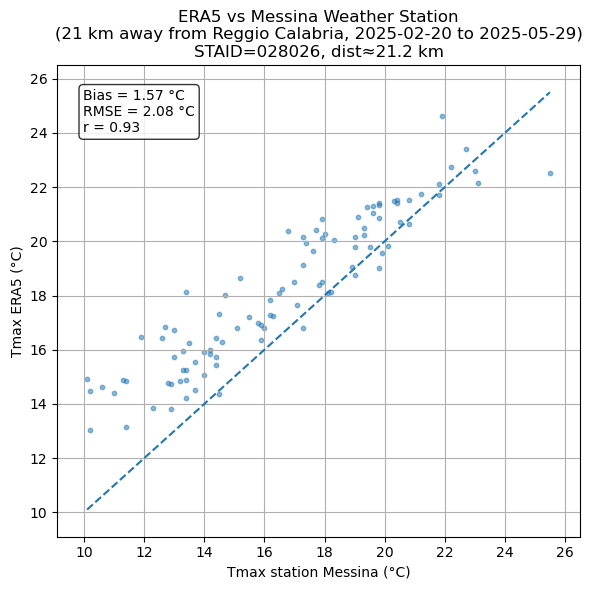


FIGURE 5 global metrics (ERA5 anomalies, summers 2020–2025):
Correlation of anomalies r (all summers): 0.89
Std of anomaly difference σ(Δanom) (all summers): 1.85 °C

Per-summer metrics:
  2020: r = 0.91, σ(Δanom) = 1.65 °C, N = 92 days
  2021: r = 0.93, σ(Δanom) = 1.87 °C, N = 92 days
  2022: r = 0.79, σ(Δanom) = 1.95 °C, N = 92 days
  2023: r = 0.96, σ(Δanom) = 2.01 °C, N = 92 days
  2024: r = 0.78, σ(Δanom) = 1.82 °C, N = 92 days
  2025: r = 0.85, σ(Δanom) = 1.54 °C, N = 92 days


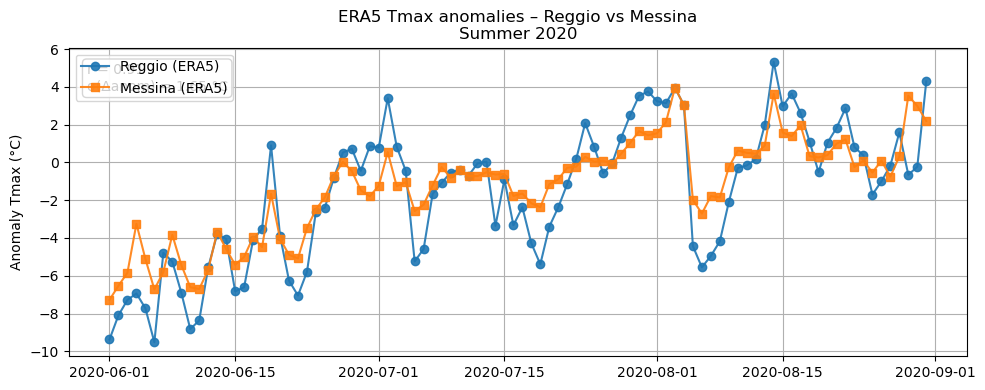

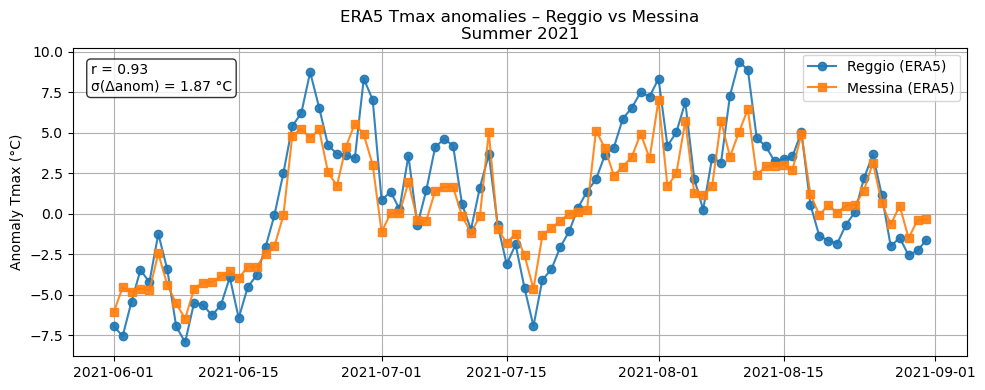

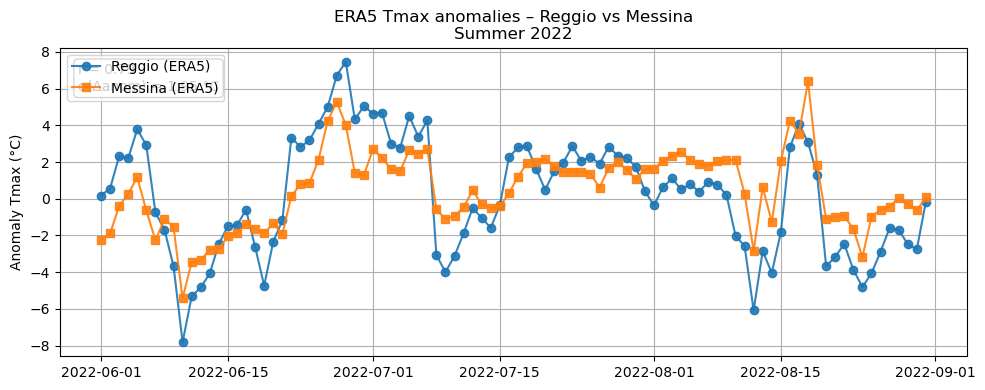

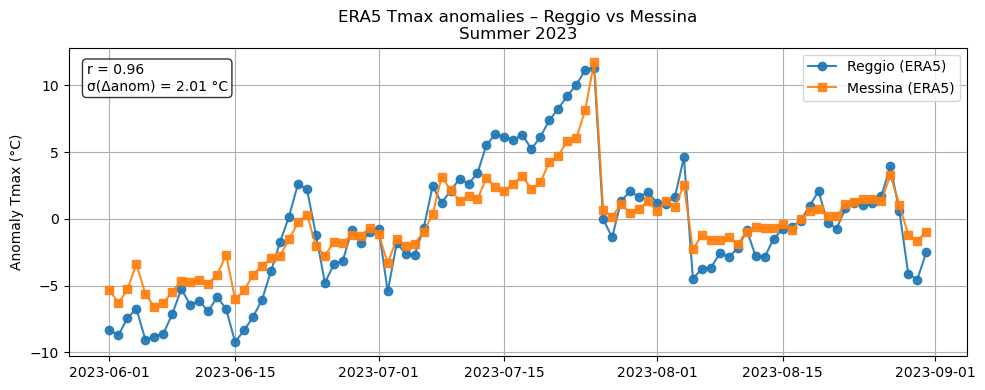

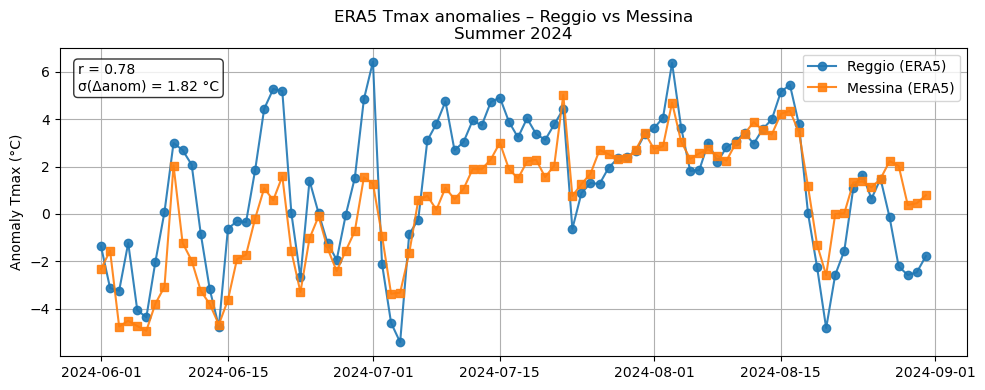

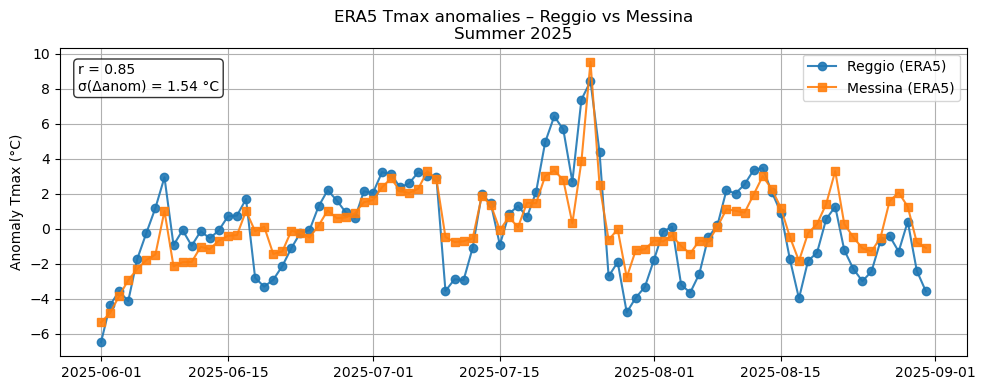

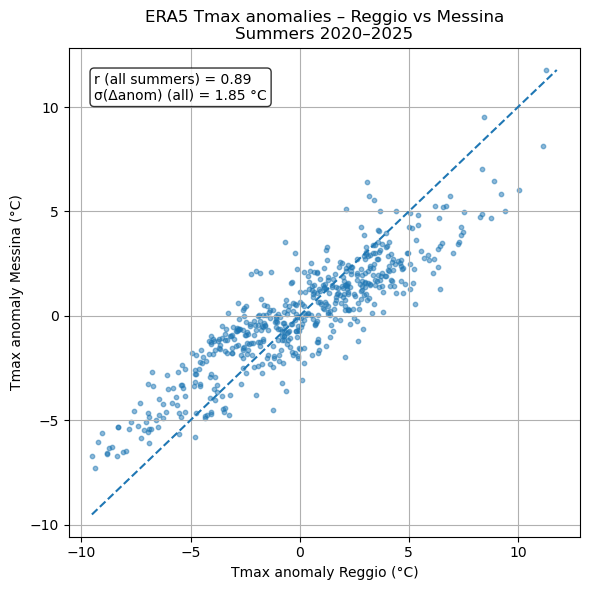

C:\Users\mfmr2\AppData\Local\Temp\ipykernel_14836\2504506564.py:465: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_poly = aoi_gdf.geometry.unary_union


Plotting summers: [2023, 2024, 2025]

Year 2023 — ERA5 AOI mean (first 5 days):
valid_time
2023-06-01    21.319702
2023-06-02    20.648956
2023-06-03    21.907745
2023-06-04    23.098450
2023-06-05    20.613464
Name: t2m, dtype: float32


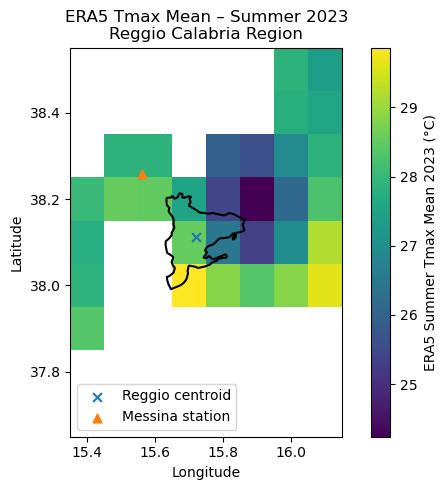


Year 2024 — ERA5 AOI mean (first 5 days):
valid_time
2024-06-01    27.154510
2024-06-02    26.113251
2024-06-03    24.958160
2024-06-04    26.739716
2024-06-05    24.539459
Name: t2m, dtype: float32


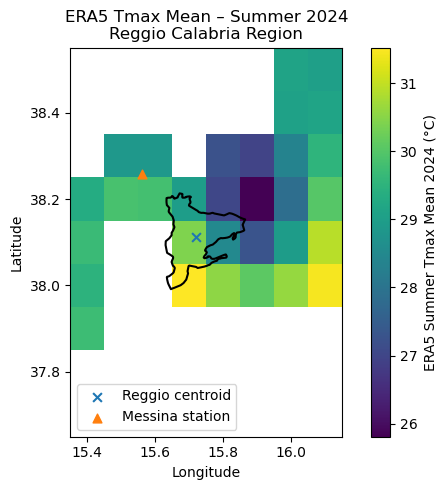


Year 2025 — ERA5 AOI mean (first 5 days):
valid_time
2025-06-01    22.562408
2025-06-02    24.288116
2025-06-03    25.178680
2025-06-04    25.103241
2025-06-05    26.909332
Name: t2m, dtype: float32


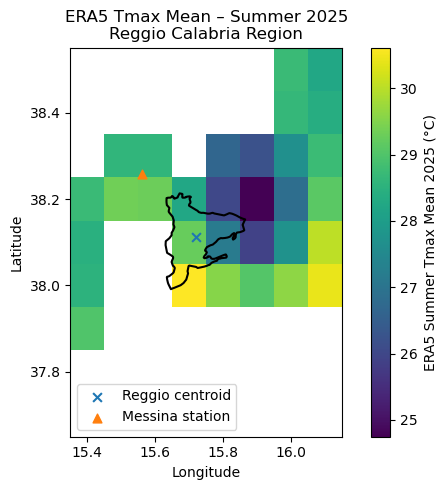

In [15]:
# ============================================================
# 01_era5_vs_stations.ipynb – FIGURE 4 + FIGURE 5 (+ extras)
# ============================================================

from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd   # for AOI and stations
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point  # >>> NEW: for AOI gridpoints

plt.rcParams["axes.grid"] = True

# --------------------------------------------------------------------
# 0. PATHS (YOUR LOCAL SETUP)
# --------------------------------------------------------------------
DATA_DIR     = Path(r"D:\Polimi\GenHack 2025\Data")
STATIONS_DIR = DATA_DIR / "ECA_blend_tx"
ERA5_DIR     = DATA_DIR / "derived-era5-land-daily-statistics"

print("DATA_DIR:           ", DATA_DIR)
print("STATIONS_DIR exists:", STATIONS_DIR.exists())
print("ERA5_DIR exists:    ", ERA5_DIR.exists())

# --------------------------------------------------------------------
# 1. HELPERS
# --------------------------------------------------------------------
def dms_to_dd_ecad(s):
    """
    Convert DMS string from ECAD ('+38:11:00', '-05:30:00', etc.) to decimal degrees.
    """
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if not s:
        return np.nan

    sign = -1 if s[0] == "-" else 1
    if s[0] in "+-":
        s = s[1:]

    parts = s.split(":")
    if len(parts) != 3:
        return np.nan

    d, m, sec = map(float, parts)
    return sign * (d + m / 60.0 + sec / 3600.0)


def load_era5_tmax_celsius():
    """
    Load ERA5-Land daily maximum 2m temperature (t2m) from derived files,
    return DataArray in °C plus names of lat/lon coords.
    """
    variable2statistic = {"2m_temperature": "daily_maximum"}
    variable2datavar   = {"2m_temperature": "t2m"}

    variable  = "2m_temperature"
    statistic = variable2statistic[variable]
    datavar   = variable2datavar[variable]

    pattern = str(ERA5_DIR / f"*_{variable}_{statistic}.nc")
    filepaths = sorted(glob(pattern))
    if not filepaths:
        raise FileNotFoundError(f"No ERA5 files found matching {pattern}")

    print(f"\nLoading ERA5 files ({len(filepaths)}):")
    for fp in filepaths:
        print("  ", fp)

    ds = xr.open_mfdataset(filepaths, combine="by_coords")

    # Coordinate names may be latitude/longitude or lat/lon
    if "latitude" in ds.coords:
        lat_name = "latitude"
    elif "lat" in ds.coords:
        lat_name = "lat"
    else:
        raise KeyError("Could not find latitude coordinate in ERA5 dataset")

    if "longitude" in ds.coords:
        lon_name = "longitude"
    elif "lon" in ds.coords:
        lon_name = "lon"
    else:
        raise KeyError("Could not find longitude coordinate in ERA5 dataset")

    da_kelvin = ds[datavar]
    da_celsius = da_kelvin - 273.15
    da_celsius.attrs["units"] = "degC"

    return da_celsius, lat_name, lon_name


def haversine_km(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between two points (deg) in km.
    """
    R = 6371.0  # Earth radius km
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


# --------------------------------------------------------------------
# 2. DEFINE REGGIO "CENTROID" (HARDCODED) & LOAD STATION METADATA
# --------------------------------------------------------------------
# Reggio centroid obtained with QGIS
REGGIO_LAT = 38.11275
REGGIO_LON = 15.71822
print(f"\nReggio fixed centroid: lat={REGGIO_LAT:.6f}, lon={REGGIO_LON:.6f}")

meta_path = STATIONS_DIR / "stations.txt"
print("Metadata file exists:", meta_path.exists())

# 2.1 Find header line that starts with 'STAID'
header_line_idx = None
with open(meta_path, "r", encoding="latin1") as f:
    for i, line in enumerate(f):
        if line.startswith("STAID"):
            header_line_idx = i
            print("Found header at line index:", i)
            print("Header line content:", line.strip())
            break

if header_line_idx is None:
    raise RuntimeError("Could not find header line starting with 'STAID' in stations.txt")

# 2.2 Read station metadata from that line
stations_meta_raw = pd.read_csv(
    meta_path,
    skiprows=header_line_idx,   # skip everything before "STAID,..."
    sep=",",
    engine="python",
)

stations_meta_raw.columns = [c.strip() for c in stations_meta_raw.columns]
stations_meta = stations_meta_raw.copy()

stations_meta["STAID"]   = stations_meta["STAID"].astype(int)
stations_meta["STANAME"] = stations_meta["STANAME"].str.strip()
stations_meta["CN"]      = stations_meta["CN"].str.strip()

stations_meta["LAT_dd"] = stations_meta["LAT"].apply(dms_to_dd_ecad)
stations_meta["LON_dd"] = stations_meta["LON"].apply(dms_to_dd_ecad)

print("\nStation metadata sample:")
print(stations_meta[["STAID", "STANAME", "CN", "LAT_dd", "LON_dd"]].head())

# --------------------------------------------------------------------
# 3. FIND NEAREST STATION TO REGGIO CENTROID
# --------------------------------------------------------------------
valid_coords = stations_meta.dropna(subset=["LAT_dd", "LON_dd"]).copy()

valid_coords["dist_km"] = haversine_km(
    REGGIO_LAT, REGGIO_LON, valid_coords["LAT_dd"], valid_coords["LON_dd"]
)

nearest_reggio_station = valid_coords.loc[valid_coords["dist_km"].idxmin()]

REGGIO_STAID = int(nearest_reggio_station["STAID"])
REGGIO_STA_LAT = nearest_reggio_station["LAT_dd"]
REGGIO_STA_LON = nearest_reggio_station["LON_dd"]
REGGIO_STA_DIST = nearest_reggio_station["dist_km"]

print("\nNearest ECAD station to Reggio centroid:")
print(nearest_reggio_station[["STAID", "STANAME", "CN", "LAT_dd", "LON_dd", "dist_km"]])

print(
    f"\nUsing station STAID={REGGIO_STAID} as Reggio station "
    f"(distance ≈ {REGGIO_STA_DIST:.1f} km)"
)

# >>> NEW: also print the 5 closest stations
closest5 = valid_coords.nsmallest(5, "dist_km")[
    ["STAID", "STANAME", "CN", "LAT_dd", "LON_dd", "dist_km"]
]
print("\nFive closest ECAD stations to Reggio centroid:")
print(closest5.to_string(index=False))

# --------------------------------------------------------------------
# 4. ALSO GET MESSINA COORDINATES (FROM ITS STATION) FOR FIGURE 5
# --------------------------------------------------------------------
messina_candidates = stations_meta[
    stations_meta["STANAME"].str.contains("MESSINA", case=False, na=False)
].copy()

print("\nMessina station candidates:")
print(messina_candidates[["STAID", "STANAME", "LAT_dd", "LON_dd"]])

if len(messina_candidates) == 0:
    raise RuntimeError("No station with name containing 'MESSINA' found in metadata")

messina_station = messina_candidates.iloc[0]
MESSINA_LAT = messina_station["LAT_dd"]
MESSINA_LON = messina_station["LON_dd"]

print(
    f"\nMessina coordinates for ERA5: lat={MESSINA_LAT:.4f}, lon={MESSINA_LON:.4f} "
    f"(from station STAID={int(messina_station['STAID'])})"
)

# --------------------------------------------------------------------
# 5. LOAD ERA5 DAILY TMAX (°C) AND EXTRACT SERIES
# --------------------------------------------------------------------
tmax_era5_c, lat_name, lon_name = load_era5_tmax_celsius()
print("\nERA5 datarray summary:", tmax_era5_c)

coords_reggio  = {lat_name: REGGIO_LAT,        lon_name: REGGIO_LON}
coords_messina = {lat_name: MESSINA_LAT,       lon_name: MESSINA_LON}
coords_reggio_sta = {lat_name: REGGIO_STA_LAT, lon_name: REGGIO_STA_LON}

# ERA5 at Reggio *centroid* (for anomalies + could also use for FIG4)
era5_reggio_da = tmax_era5_c.sel(coords_reggio, method="nearest")
era5_reggio_series = era5_reggio_da.to_series().sort_index()

# ERA5 at Messina
era5_messina_da = tmax_era5_c.sel(coords_messina, method="nearest")
era5_messina_series = era5_messina_da.to_series().sort_index()

# ERA5 at the *station* location nearest to Reggio (for FIG4 scatter)
era5_reggio_sta_da = tmax_era5_c.sel(coords_reggio_sta, method="nearest")
era5_reggio_sta_series = era5_reggio_sta_da.to_series().sort_index()

print("\nERA5 Reggio (centroid) series head:")
print(era5_reggio_series.head())
print("\nERA5 Messina series head:")
print(era5_messina_series.head())
print("\nERA5 Reggio-station (nearest grid point) series head:")
print(era5_reggio_sta_series.head())

# --------------------------------------------------------------------
# 6. LOAD STATION DAILY TX FOR NEAREST REGGIO STATION – FIGURE 4
# --------------------------------------------------------------------
station_data_path = STATIONS_DIR / f"TX_STAID{REGGIO_STAID:06d}.txt"
print("\nNearest station data file:", station_data_path, 
      "exists:", station_data_path.exists())

station_df = pd.read_csv(
    station_data_path,
    skiprows=20,
    skipinitialspace=True,
)

# Good quality only
valid_station_df = station_df[station_df["Q_TX"] == 0].copy()
valid_station_df["DATE"] = pd.to_datetime(valid_station_df["DATE"], format="%Y%m%d")
valid_station_df["TX_celsius"] = valid_station_df["TX"] / 10.0  # 0.1 °C → °C

tx_station_series = pd.Series(
    valid_station_df["TX_celsius"].values,
    index=valid_station_df["DATE"],
).sort_index()

print("\nNearest station (Messina) TX series head:")
print(tx_station_series.head())

# --------------------------------------------------------------------
# 7. FIGURE 4 – ERA5 VS NEAREST STATION (MESSINA, 21 km FROM REGGIO)
# --------------------------------------------------------------------
# Use all overlapping days between ERA5 and station series
pair_df = pd.DataFrame({
    "station_TX": tx_station_series,
    "era5_TX": era5_reggio_sta_series,
}).dropna()

pair_df["diff"] = pair_df["era5_TX"] - pair_df["station_TX"]

bias = pair_df["diff"].mean()
rmse = np.sqrt((pair_df["diff"] ** 2).mean())
corr = pair_df["station_TX"].corr(pair_df["era5_TX"])

print("\nFIGURE 4 metrics (ERA5 vs Weather station – Messina):")
print(f"Bias  (ERA5 - station): {bias:.2f} °C")
print(f"RMSE:                   {rmse:.2f} °C")
print(f"Correlation r:          {corr:.2f}")

# Period string for the title
start_date = pair_df.index.min().strftime("%Y-%m-%d")
end_date   = pair_df.index.max().strftime("%Y-%m-%d")
period_str = f"{start_date} to {end_date}"

plt.figure(figsize=(6, 6))
ax = plt.gca()

ax.scatter(pair_df["station_TX"], pair_df["era5_TX"], s=10, alpha=0.5)

# 1:1 line based only on station + ERA5 values
vmin = min(pair_df["station_TX"].min(), pair_df["era5_TX"].min())
vmax = max(pair_df["station_TX"].max(), pair_df["era5_TX"].max())
ax.plot([vmin, vmax], [vmin, vmax], "--", label="1:1 line")

# Axis labels and limits (tight around data)
pad = 1.0  # °C padding
ax.set_xlim(vmin - pad, vmax + pad)
ax.set_ylim(vmin - pad, vmax + pad)

ax.set_xlabel("Tmax station Messina (°C)")
ax.set_ylabel("Tmax ERA5 (°C)")
ax.set_title(
    "ERA5 vs Messina Weather Station\n"
    f"(21 km away from Reggio Calabria, {period_str})\n"
    f"STAID={REGGIO_STAID:06d}, dist≈{REGGIO_STA_DIST:.1f} km"
)

txt = f"Bias = {bias:.2f} °C\nRMSE = {rmse:.2f} °C\nr = {corr:.2f}"
ax.text(
    0.05,
    0.95,
    txt,
    transform=ax.transAxes,
    va="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 8. FIGURE 5 – ANOMALIES ERA5 REGGIO (CENTROID) VS MESSINA (ALL SUMMERS)
# --------------------------------------------------------------------
tx_reggio  = era5_reggio_series.copy()
tx_messina = era5_messina_series.copy()

summer_months = [6, 7, 8]

# Use ALL summers available in the series (no hard-coded year upper bound)
mask_reggio = tx_reggio.index.month.isin(summer_months)
mask_messina = tx_messina.index.month.isin(summer_months)

tx_reggio_summer  = tx_reggio.loc[mask_reggio]
tx_messina_summer = tx_messina.loc[mask_messina]

# Combine and keep only dates where both series are available
anom_df = pd.DataFrame({
    "reggio": tx_reggio_summer,
    "messina": tx_messina_summer,
}).dropna()

if anom_df.empty:
    raise RuntimeError("No overlapping summer data found between Reggio and Messina ERA5 series.")

# Mean over ALL summers (used to define anomalies)
mean_reggio_summer  = anom_df["reggio"].mean()
mean_messina_summer = anom_df["messina"].mean()

anom_df["anom_reggio"]  = anom_df["reggio"]  - mean_reggio_summer
anom_df["anom_messina"] = anom_df["messina"] - mean_messina_summer

# -------- GLOBAL METRICS (ALL SUMMERS TOGETHER) --------
corr_anom = anom_df["anom_reggio"].corr(anom_df["anom_messina"])
std_diff  = (anom_df["anom_reggio"] - anom_df["anom_messina"]).std()

start_year = int(anom_df.index.year.min())
end_year   = int(anom_df.index.year.max())

print(f"\nFIGURE 5 global metrics (ERA5 anomalies, summers {start_year}–{end_year}):")
print(f"Correlation of anomalies r (all summers): {corr_anom:.2f}")
print(f"Std of anomaly difference σ(Δanom) (all summers): {std_diff:.2f} °C")

# ---- PER-SUMMER METRICS (just to inspect) ----
summer_years = sorted(anom_df.index.year.unique())
print("\nPer-summer metrics:")
for y in summer_years:
    df_y = anom_df[anom_df.index.year == y]
    r_y = df_y["anom_reggio"].corr(df_y["anom_messina"])
    std_y = (df_y["anom_reggio"] - df_y["anom_messina"]).std()
    n_y = len(df_y)
    print(f"  {y}: r = {r_y:.2f}, σ(Δanom) = {std_y:.2f} °C, N = {n_y} days")

# ---- FIGURE 5A – TIME SERIES OF ANOMALIES, ONE PLOT PER SUMMER ----
for y in summer_years:
    anom_year = anom_df[anom_df.index.year == y]

    # Per-summer metrics for annotation
    r_y = anom_year["anom_reggio"].corr(anom_year["anom_messina"])
    std_y = (anom_year["anom_reggio"] - anom_year["anom_messina"]).std()

    plt.figure(figsize=(10, 4))
    ax = plt.gca()

    ax.plot(
        anom_year.index,
        anom_year["anom_reggio"],
        marker="o",
        linestyle="-",
        label="Reggio (ERA5)",
        alpha=0.9,
    )
    ax.plot(
        anom_year.index,
        anom_year["anom_messina"],
        marker="s",
        linestyle="-",
        label="Messina (ERA5)",
        alpha=0.9,
    )

    ax.set_title(f"ERA5 Tmax anomalies – Reggio vs Messina\nSummer {y}")
    ax.set_ylabel("Anomaly Tmax (°C)")
    ax.legend()

    # Annotate with metrics for THIS summer
    txt = f"r = {r_y:.2f}\nσ(Δanom) = {std_y:.2f} °C"
    ax.text(
        0.02,
        0.95,
        txt,
        transform=ax.transAxes,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

# ---- FIGURE 5B – SCATTER OF ANOMALIES (ALL SUMMERS TOGETHER) ----
plt.figure(figsize=(6, 6))
ax = plt.gca()

ax.scatter(
    anom_df["anom_reggio"],
    anom_df["anom_messina"],
    s=10,
    alpha=0.5,
)

vmin = min(anom_df[["anom_reggio", "anom_messina"]].min())
vmax = max(anom_df[["anom_reggio", "anom_messina"]].max())
ax.plot([vmin, vmax], [vmin, vmax], "--", label="1:1 line")

ax.set_xlabel("Tmax anomaly Reggio (°C)")
ax.set_ylabel("Tmax anomaly Messina (°C)")
ax.set_title(f"ERA5 Tmax anomalies – Reggio vs Messina\nSummers {start_year}–{end_year}")

txt = f"r (all summers) = {corr_anom:.2f}\nσ(Δanom) (all) = {std_diff:.2f} °C"
ax.text(
    0.05,
    0.95,
    txt,
    transform=ax.transAxes,
    va="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 9. AOI + AREAL REPRESENTATIVITY + SPATIAL MAP (ONE MAP PER SUMMER)
# --------------------------------------------------------------------

AOI_PATH = DATA_DIR / "Limite_comunale_Reggio_di_Calabria" / "080063.shp"
aoi_gdf = gpd.read_file(AOI_PATH).to_crs(epsg=4326)
aoi_poly = aoi_gdf.geometry.unary_union

# --- Identify available summer years from ERA5 ---
years_available = sorted(era5_reggio_series.index.year.unique())
summer_years = [y for y in years_available if y >= (years_available[-1] - 2)]
print("Plotting summers:", summer_years)

buffer_deg = 0.3

for y in summer_years:

    # --- Select ERA5 for this specific summer ---
    summer_sel = tmax_era5_c.sel(valid_time=slice(f"{y}-06-01", f"{y}-08-31"))

    if summer_sel.valid_time.size == 0:
        print(f"Skipping year {y}: no summer data found.")
        continue

    # Mean of this summer
    tmax_summer_mean = summer_sel.mean("valid_time")

    # Bounding box around AOI
    minx, miny, maxx, maxy = aoi_gdf.total_bounds

    lat_vals = summer_sel[lat_name].values
    lon_vals = summer_sel[lon_name].values

    # latitude may be descending
    if lat_vals[0] > lat_vals[-1]:
        lat_mask = (lat_vals <= maxy + buffer_deg) & (lat_vals >= miny - buffer_deg)
    else:
        lat_mask = (lat_vals >= miny - buffer_deg) & (lat_vals <= maxy + buffer_deg)

    lon_mask = (lon_vals >= minx - buffer_deg) & (lon_vals <= maxx + buffer_deg)

    lat_sub = lat_vals[lat_mask]
    lon_sub = lon_vals[lon_mask]

    summer_window = summer_sel.sel({lat_name: lat_sub, lon_name: lon_sub})
    tmax_summer_mean_sub = tmax_summer_mean.sel({lat_name: lat_sub, lon_name: lon_sub})

    # Construct a point grid
    lon_grid, lat_grid = np.meshgrid(lon_sub, lat_sub)
    points = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in zip(lon_grid.ravel(), lat_grid.ravel())],
        crs="EPSG:4326",
    )

    inside_mask = points.within(aoi_poly).values.reshape(lat_grid.shape)

    inside_mask_da = xr.DataArray(
        inside_mask,
        coords={lat_name: lat_sub, lon_name: lon_sub},
        dims=(lat_name, lon_name),
    )

    # ERA5 inside AOI only
    era5_aoi_summer = summer_window.where(inside_mask_da, drop=True)

    # AOI-mean summer time series
    era5_reggio_aoi_series = (
        era5_aoi_summer.mean(dim=[lat_name, lon_name]).to_series().sort_index()
    )

    print(f"\nYear {y} — ERA5 AOI mean (first 5 days):")
    print(era5_reggio_aoi_series.head())

    # --- Plot the spatial map for this summer ---
    plt.figure(figsize=(6, 5))
    ax = plt.gca()

    tmax_summer_mean_sub.plot(
        ax=ax,
        add_colorbar=True,
        cbar_kwargs={"label": f"ERA5 Summer Tmax Mean {y} (°C)"},
    )

    aoi_gdf.boundary.plot(ax=ax, linewidth=1.5, edgecolor="k")

    ax.scatter(REGGIO_LON, REGGIO_LAT, marker="x", s=40, label="Reggio centroid")
    ax.scatter(MESSINA_LON, MESSINA_LAT, marker="^", s=40, label="Messina station")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"ERA5 Tmax Mean – Summer {y}\nReggio Calabria Region")
    ax.legend(loc="lower left")

    plt.tight_layout()
    plt.show()


Overall, the analyses show that Reggio and Messina share very similar day-to-day summer temperature variability (r ≈ 0.9), meaning both locations react almost identically to large-scale warm and cool spells. Messina is therefore a reliable proxy for the timing of temperature changes in Reggio. However, the two ERA5 grid cells routinely differ by ±1.5–2 °C in their daily anomaly values, introducing a clear representativity uncertainty: Messina reflects when Reggio warms or cools, but not exactly how much. 

A second limitation comes from the lack of good-quality station data in the area, especially during summer, which means we cannot directly verify how accurate ERA5 is for Messina on the hottest days. Because of this, ERA5 is reliable for understanding how temperatures change from day to day, but we cannot fully trust the exact numerical values it gives for Reggio. In other words, ERA5 is good for studying patterns and anomalies, but not for determining the precise local temperature on any given summer day. 

For UHI modelling, this means that ERA5 provides a solid basis for capturing variability and relative changes, but any downscaled UHI signal will inherit an uncertainty of about ±2 °C unless additional local observations become available. 

Despite the limitations in station coverage and the representativity uncertainty between ERA5 grid cells, the Reggio–Messina area still provides enough reliable information to study UHI patterns. ERA5 captures day-to-day variability well, and NDVI offers strong spatial detail, allowing us to model how local surface characteristics modify temperature. Therefore, we will continue working in this zone, as it remains fully suitable for visualizing UHI behavior and for proposing a meaningful downscaling approach within the goals of the hackathon. 

## Extra Diagnosis not used for the objective of this script

In [6]:
# --- Diagnostics: what does the station file actually contain? ---
diag_df = station_df.copy()
diag_df["DATE"] = pd.to_datetime(diag_df["DATE"], format="%Y%m%d")

print("\nRaw station period (before quality filter):")
print("Min DATE:", diag_df["DATE"].min())
print("Max DATE:", diag_df["DATE"].max())

# How many days per year and per quality flag?
diag_df["year"] = diag_df["DATE"].dt.year
print("\nCounts by year and Q_TX:")
print(diag_df.groupby(["year", "Q_TX"])["DATE"].count())



Raw station period (before quality filter):
Min DATE: 2025-02-01 00:00:00
Max DATE: 2025-08-31 00:00:00

Counts by year and Q_TX:
year  Q_TX
2025  0        99
      9       113
Name: DATE, dtype: int64


In [10]:
# ------------------------------------------------------------
# DIAGNOSTICS: Full summary of the station file (TX_STAIDxxxxx)
# ------------------------------------------------------------
station_file = station_data_path  # already defined in your script

df_raw = pd.read_csv(
    station_file,
    skiprows=20,
    skipinitialspace=True,
)

# Convert DATE column
df_raw["DATE"] = pd.to_datetime(df_raw["DATE"], format="%Y%m%d")
df_raw["year"] = df_raw["DATE"].dt.year
df_raw["month"] = df_raw["DATE"].dt.month

print("\n--- WEATHER STATION DIAGNOSTICS ---\n")

print("File:", station_file)
print("Total rows:", len(df_raw))

print("\nDate range:")
print("  Min DATE:", df_raw["DATE"].min())
print("  Max DATE:", df_raw["DATE"].max())

print("\nCounts by Q_TX (quality flags):")
print(df_raw["Q_TX"].value_counts().sort_index())

print("\nCounts by year and Q_TX:")
print(df_raw.groupby(["year", "Q_TX"])["DATE"].count())

print("\nCounts by year, month and Q_TX:")
print(df_raw.groupby(["year", "month", "Q_TX"])["DATE"].count())

# Number of good-quality days
good_df = df_raw[df_raw["Q_TX"] == 0]
print("\nGood-quality records (Q_TX = 0):", len(good_df))

print("\nGood-quality period:")
print("  Min good DATE:", good_df["DATE"].min())
print("  Max good DATE:", good_df["DATE"].max())

print("\n-----------------------------------\n")



--- WEATHER STATION DIAGNOSTICS ---

File: D:\Polimi\GenHack 2025\Data\ECA_blend_tx\TX_STAID028026.txt
Total rows: 212

Date range:
  Min DATE: 2025-02-01 00:00:00
  Max DATE: 2025-08-31 00:00:00

Counts by Q_TX (quality flags):
Q_TX
0     99
9    113
Name: count, dtype: int64

Counts by year and Q_TX:
year  Q_TX
2025  0        99
      9       113
Name: DATE, dtype: int64

Counts by year, month and Q_TX:
year  month  Q_TX
2025  2      0        9
             9       19
      3      0       31
      4      0       30
      5      0       29
             9        2
      6      9       30
      7      9       31
      8      9       31
Name: DATE, dtype: int64

Good-quality records (Q_TX = 0): 99

Good-quality period:
  Min good DATE: 2025-02-20 00:00:00
  Max good DATE: 2025-05-29 00:00:00

-----------------------------------



In [11]:
import glob
import pandas as pd

all_q = []

for path in glob.glob(str(STATIONS_DIR / "TX_STAID*.txt")):
    df = pd.read_csv(path, skiprows=20, skipinitialspace=True, usecols=["Q_TX"])
    all_q.append(df["Q_TX"])

all_q = pd.concat(all_q)
print(all_q.value_counts().sort_index())


Q_TX
0    133209364
1       334185
9     42071925
Name: count, dtype: int64
